In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from google.cloud import bigquery
import os
from google.cloud import bigquery

from datetime import timedelta
import warnings

os.chdir('/home/jupyter')
!pwd
# # %cd 
# !pwd


from IPython.display import HTML

import refinitiv.dataplatform as rdp

%run ./starfire/notebooks/credentials.ipynb

session = rdp.open_platform_session(
    APP_KEY,
    rdp.GrantPassword(
        username = RDP_LOGIN,
        password = RDP_PASSWORD
    )
)


/home/jupyter


In [26]:
#load deals data
df_deals = pd.read_csv('data/refi_deals_2018.csv')
print(df_deals.shape)

(58384, 75)


In [28]:
# Create list of acquiror tickers from deals df to pass into next query

tickers = df_deals[
    (df_deals['TR.MnAAcquirorPriTickerSym'] != "") & 
    (df_deals['TR.MnAAcquirorPriTickerSym'].notna()) 
][['TR.MnAAcquirorPriTickerSym']]

print(tickers)

ticker_list = tickers['TR.MnAAcquirorPriTickerSym'].tolist()


      TR.MnAAcquirorPriTickerSym
1                           BDMN
2                         BBU.UN
10                         COLUM
13                          1202
16                           ARW
...                          ...
58353                        ACK
58356                       PENG
58361                     002675
58374                       6782
58378                        JEF

[16380 rows x 1 columns]


In [29]:

# Get symbols for all tickers. Need to process in chunks to avoid refinitiv's api to time out
chunk_results = []
chunk_size = 500
print(f'length: {len(ticker_list)}')
for start in range(0, len(ticker_list), chunk_size):
    end = min(start + chunk_size, len(ticker_list))
    print(f'{start}:{end}')
    ticker_chunk = ticker_list[start:end]
    chunk_result = rdp.convert_symbols(
        ticker_chunk, 
        from_symbol_type='TICKER'
    )
    chunk_results.append(chunk_result)
    # print(chunk_results)
    
# Concatenate all chunk results into a final DataFrame
symbols = pd.concat(chunk_results, ignore_index=True)
symbols


length: 16380
0:500
500:1000
1000:1500
1500:2000
2000:2500
2500:3000
3000:3500
3500:4000
4000:4500
4500:5000
5000:5500
5500:6000
6000:6500
6500:7000
7000:7500
7500:8000
8000:8500
8500:9000
9000:9500
9500:10000
10000:10500
10500:11000
11000:11500
11500:12000
12000:12500
12500:13000
13000:13500
13500:14000
14000:14500
14500:15000
15000:15500
15500:16000
16000:16380


,IssueISIN,FundClassLipperID,IssuerOAPermID,CUSIP,SEDOL,TickerSymbol,RIC,DocumentTitle
0,ID1000094204,<NA>,4295874431,<NA>,6580034,BDMN,BDMN.JK,"Bank Danamon Indonesia Tbk PT, Ordinary Share,..."
1,BMG162341090,68578481,5046722004,<NA>,BYNDNQ0,BBU.UN,BBU_u.TO,"Brookfield Business Partners LP, Unit, The Tor..."
2,DK0010268366,<NA>,4295866048,<NA>,5960916,COLUM,COLUM.CO,"Columbus A/S, Ordinary Share, OMX Nordic Excha..."
3,CNE1000002C2,<NA>,4295864118,<NA>,6203546,1202,1202.HK,"Chengdu SIWI Science and Technology Co Ltd, Or..."
4,US0427351004,<NA>,4295903472,042735100,<NA>,ARW,ARW,"Arrow Electronics Inc, Ordinary Share, NYSE Co..."
...,...,...,...,...,...,...,...,...
13629,MHY7545W1259,<NA>,5037847419,<NA>,<NA>,SDLP,SDLP.W^E14,"Seadrill Partners Units, Unit, Delisted, Chica..."
13630,JP3160300004,<NA>,4295880278,<NA>,7552184,ACK,5017.F,"Fuji Oil Co Ltd, Ordinary Share, Frankfurt Sto..."
13631,<NA>,<NA>,<NA>,<NA>,<NA>,PENG,AI-PENG.OL^L07,"AI-PENG, Open-End Fund, Delisted, Oslo Stock E..."
13632,TW0006782006,<NA>,5035300917,<NA>,BM9WRL0,6782,6782.TW,"Visco Vision Inc, Ordinary Share, Taiwan Stock..."


In [30]:
# Bring symbols back to main deals dataframe, merge on ticker. Also, drop repeated observations created from symbols df

# Perform a left merge on the 'TickerSymbol' column
df_deals = pd.merge(df_deals, symbols, how='left', left_on='TR.MnAAcquirorPriTickerSym', right_on='TickerSymbol')
print(df_deals.shape)
df_deals = df_deals.drop_duplicates(subset=['TR.MNASDCDealNumber'], keep='first') # Drop duplicate deals, I didn't find the source of duplicates
print(df_deals.shape)

df_deals

(84582, 83)
(58384, 83)


,Unnamed: 0,instrument,TR.MNASDCDealNumber,TR.MnAAnnDate,TR.MnARankValueIncNetDebt,TR.MnATarget,TR.MnATargetPermId,TR.MnATargetPriTickerSym,TR.MnATargetNation,TR.MnATargetMacroInd,...,TR.MnADealCurrency,TR.MnAEarnoutDesc,IssueISIN,FundClassLipperID,IssuerOAPermID,CUSIP,SEDOL,TickerSymbol,RIC,DocumentTitle
0,0,154081636364,2696976040,2018-01-06,602.623335,Belgrade Nikola Tesla Airport Jsc-Concession,NaN,NaN,Serbia,Industrials,...,Serbian Dinar,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,154083046842,2951155040,2018-01-02,110.927885,Bank Nusantara Parahyangan Tbk PT,4.295874e+09,BBNP,Indonesia,Financials,...,Indonesian Rupiah,NaN,ID1000094204,<NA>,4295874431,<NA>,6580034,BDMN,BDMN.JK,"Bank Danamon Indonesia Tbk PT, Ordinary Share,..."
2,2,154083214825,3081061020,2018-01-04,4600.000000,Westinghouse Electric Co LLC,4.297335e+09,NaN,United States,Energy and Power,...,US Dollar,NaN,BMG162341090,68578481,5046722004,<NA>,BYNDNQ0,BBU.UN,BBU_u.TO,"Brookfield Business Partners LP, Unit, The Tor..."
6,3,154083245535,3104001040,2018-01-02,360.923874,AVIC International Vanke Co Ltd,NaN,NaN,China (Mainland),Real Estate,...,Chinese Yuan,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,4,154083250434,3107974040,2018-01-02,NaN,L'Appart SAS,5.056390e+09,NaN,France,Retail,...,Euro,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84577,58379,154087656025,3955160040,2019-01-11,NaN,Jokkmokks Korv AB,5.045247e+09,NaN,Sweden,Consumer Staples,...,US Dollar,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
84578,58380,154088013950,4087420020,2019-01-09,0.750000,TaxBit Inc,5.067500e+09,NaN,United States,High Technology,...,US Dollar,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
84579,58381,154088083578,4099143020,2019-01-08,NaN,Clique Media Inc,5.047746e+09,NaN,United States,High Technology,...,US Dollar,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
84580,58382,154088155027,4129515020,2019-01-09,NaN,Aero Turbine Inc,5.045899e+09,NaN,United States,Industrials,...,US Dollar,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [42]:


## Iterate over df_deals to get stock price data for days around acquisition

# Suppress warnings -- reinstated at the end of the loop
warnings.filterwarnings("ignore")

# Ensure 'TR.MnAAnnDate' is in datetime format
df_deals['TR.MnAAnnDate'] = pd.to_datetime(df_deals['TR.MnAAnnDate'])
df_deals['RIC'] = df_deals['RIC'].str.strip()  # Remove leading/trailing spaces

# Initialize an empty DataFrame to store the results
stock_prices_df = pd.DataFrame()
# Initialize an empty DataFrame to store error information
error_log = pd.DataFrame(columns=['Index', 'RIC', 'Error'])

# Counter to track the number of lines processed
counter = 0

print(f"Downloading stock market prices for {len(df_deals[df_deals['RIC'].notna() & (df_deals['RIC'] != '')])} RICs...")
# Loop through the merged_df to extract the required variables. Subset on non null RIC values
for index, row in df_deals[df_deals['RIC'].notna() & (df_deals['RIC'] != '')].iterrows():

    RIC = row['RIC']
    MnAAnnDate = row['TR.MnAAnnDate']
    MNASDCDealNumber = row['TR.MNASDCDealNumber']

    # Calculate start and end dates (MnAAnnDate - 10 days and MnAAnnDate + 10 days)
    start_date = (MnAAnnDate - timedelta(days=10)).strftime('%Y-%m-%d')
    end_date = (MnAAnnDate + timedelta(days=10)).strftime('%Y-%m-%d')

    # Fetch historical price summaries
    success = False
    # while not success:
    try:

        ric_prices = rdp.get_data(RIC,
                        fields = ['TR.CLOSEPRICE.Date','TR.CLOSEPRICE', 'TR.PriceOpen', 
                          'TR.VOLUME', 'TR.SharesOutstanding', 'TR.CompanyMarketCap', 'TR.TotalReturn1D',
                          'TR.HQCountryCode', 'TR.HeadquartersRegion',  'TR.HQMinorRegion', 
                          'TR.ExchangeRegion', 'TR.ExchangeCountry','TR.ExchangeCountryCode'],
                        parameters = {'SDate':start_date,
                                      'EDate':end_date,
                                      'Curn':'USD'}
                        )

        # Add additional columns to the result (start, end, MnAAnnDate, RIC)
        ric_prices['Start'] = start_date
        ric_prices['End'] = end_date
        ric_prices['MnAAnnDate'] = MnAAnnDate
        ric_prices['RIC'] = RIC
        ric_prices['MNASDCDealNumber'] = MNASDCDealNumber
        ric_prices['loop_counter'] = counter

        # print(ric_prices)

        # Append the result to the historical_data DataFrame
        stock_prices_df = pd.concat([stock_prices_df, ric_prices], ignore_index=True)

        counter += 1
    # Print progress every 100 lines
        if counter % 100 == 0:
            print(f"Processed {counter} lines")

        success = True

    except Exception as e:
        print(f"An error occurred for index: {index}, RIC {RIC}: {e}")
        # Create a DataFrame for the error entry
        error_entry = pd.DataFrame({'Index': [index], 'RIC': [RIC], 'Error': [str(e)]})
        # Concatenate the error entry to the error_log DataFrame
        error_log = pd.concat([error_log, error_entry], ignore_index=True)

        
# Restore warnings
warnings.filterwarnings("default")

# Display the final historical_data DataFrame
print(stock_prices_df)

# Display the error log DataFrame
print(error_log)

ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 497, RIC 030270.TW: 
Processed 100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 1254, RIC FITGc1: 
Processed 200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 1521, RIC RTIc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 1772, RIC 01PUNF7: 
Processed 300 lines
Processed 400 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 2773, RIC BWQQc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 3163, RIC 01MGP6G7: 
Processed 500 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 3453, RIC DNBDFc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 3642, RIC INILc1:PSX: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 3959, RIC IVQQc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 4021, RIC PSFtmc1: 
Processed 600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 4153, RIC BIMASc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 4370, RIC TGLSY.PK^K15: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 4372, RIC TGLSY.PK^K15: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 4453, RIC PLWPc1: 
Processed 700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 4527, RIC DOFtmc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 5037, RIC LMCGc1: 
Processed 800 lines
Processed 900 lines
An error occurred for index: 5710, RIC 1ASPVMW.PIPB: 'NoneType' object does not support item assignment
An error occurred for index: 5754, RIC 1AETFC.PIPB: 'NoneType' object does not support item assignment
Processed 1000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 6675, RIC UNc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 6746, RIC 01KUUK2^1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 6770, RIC HHECc1: 
Processed 1100 lines
An error occurred for index: 6841, RIC TBSPva.BK: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 6911, RIC FB10mvc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 6928, RIC TESSc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 7072, RIC PGAc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 7105, RIC IVQQc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 7283, RIC JEZH25: 
Processed 1200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 7362, RIC CCSLHGBPV24PD: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 7523, RIC 081970.TW: 
Processed 1300 lines
An error occurred for index: 8392, RIC 1ASPPFPT.PIPB: 'NoneType' object does not support item assignment
Processed 1400 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 9110, RIC SHL37mC25.CDE: 
Processed 1500 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 9695, RIC AEBJ25: 
Processed 1600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 9955, RIC 5008.HK: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 10047, RIC FITGc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 10220, RIC POGc1: 
Processed 1700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 10472, RIC GRPCFDc1: 
An error occurred for index: 10655, RIC 1ASPVMW.PIPB: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 10870, RIC SIEGnlfrrrc60: 
Processed 1800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 11187, RIC MWClfc2: 
Processed 1900 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 11489, RIC FEDEc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 11772, RIC HSOGc1: 
Processed 2000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 11802, RIC 081970.TW: 
An error occurred for index: 11878, RIC 1ASPVMW.PIPB: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 12092, RIC CSGN2698hX4.EX: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 12397, RIC AYXc15: 
Processed 2100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 12591, RIC MINE.V: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 12806, RIC YATcm1: 
Processed 2200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 13298, RIC TAVHLc1: 
Processed 2300 lines
Processed 2400 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 14294, RIC HTGC.K: 
Processed 2500 lines
An error occurred for index: 14612, RIC 1AAIMC.PIPB: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 14630, RIC 3EPL220O8: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 14762, RIC SANlfc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 14897, RIC 2WE3W1142Q9: 
Processed 2600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 15424, RIC HIAQ24: 
Processed 2700 lines
Processed 2800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 16126, RIC SRIQ24: 
Processed 2900 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 16923, RIC WA5900L4.XD: 
Processed 3000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 17185, RIC WMDX25: 
Processed 3100 lines
Processed 3200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 18577, RIC JSWc1: 
Processed 3300 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 19038, RIC LPLPbc1:PSX: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 19320, RIC EV: 
Processed 3400 lines
Processed 3500 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 19974, RIC SMUsgc1: 
Processed 3600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 20622, RIC FMUc1:MO: 
Processed 3700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 21269, RIC GRPCFDc1: 
Processed 3800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 21751, RIC SAHOLc1: 
Processed 3900 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 22471, RIC MEO1Vc1: 
Processed 4000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 23434, RIC 2JCACc3-c7: 
Processed 4100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 26115, RIC SXRTSc1: 
Processed 4600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 26428, RIC EQMDc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 26430, RIC EQMDc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 26432, RIC EQMDc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 26433, RIC EQMDc1: 
Processed 4700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 26850, RIC HOWc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 27023, RIC AHA20000I4.EX: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 27045, RIC CN197210=SZ: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 27230, RIC BLAfxc1: 
Processed 4800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 27760, RIC 0ZNTH7: 
Processed 4900 lines
Processed 5000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 28384, RIC PAMPc1: 
An error occurred for index: 28765, RIC 0#MVTB:: 'NoneType' object does not support item assignment
Processed 5100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 28929, RIC HMPIc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 29398, RIC CMSN3: 
Processed 5200 lines
Processed 5300 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 30225, RIC CSGN2698hX4.EX: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 30343, RIC GNBc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 30411, RIC DOHOLc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 30412, RIC DOHOLc1: 
Processed 5400 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 30744, RIC LRMD102FL18J24.L: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 30885, RIC 0DBKGn2M3^1: 
Processed 5500 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 31076, RIC HIAQ24: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 31326, RIC 036490.TW: 
Processed 5600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 31487, RIC SMUsgc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 31690, RIC 2WE3W1142Q9: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 31815, RIC SNHFZ0d: 
Processed 5700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 32270, RIC KBB.TR^A08: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 32398, RIC TIFGc1: 
Processed 5800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 32986, RIC PLANBfxc1: 
Processed 5900 lines
An error occurred for index: 33172, RIC 0#MRGB:: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 33485, RIC NEWMlfc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 33493, RIC NEWMlfc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 33599, RIC 030790.TW: 
Processed 6000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 34001, RIC IMCR.BR^A09: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 34149, RIC H4Nc1: 
Processed 6100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 34449, RIC TESSc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 34512, RIC 0DBKGn2M3^1: 
Processed 6200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 34895, RIC POGc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 35105, RIC JM020500U4.ST: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 35126, RIC BIDSZ9d: 
Processed 6300 lines
An error occurred for index: 35398, RIC 1APRSP.PIPB: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 35966, RIC BUDDrrrH6-M6: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36011, RIC KBB.TR^A08: 
Processed 6400 lines
An error occurred for index: 36091, RIC 0#MVTB:: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36107, RIC SMUsgc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36111, RIC SMUsgc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36115, RIC SMUsgc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36553, RIC TRKCMc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36570, RIC YARTSc1: 
Processed 6500 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36829, RIC ESLGc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36840, RIC ICAD1600X5.p: 
An error occurred for index: 36868, RIC TIWva.BK: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 36940, RIC GZU.TR: 
Processed 6600 lines
Processed 6700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 37895, RIC BCPGfxc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 38128, RIC 036490.TW: 
Processed 6800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 38779, RIC PTCMc1: 
Processed 6900 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 38928, RIC 1FNMU7m: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 39268, RIC 033600.TW: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 39409, RIC LUXGc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 39416, RIC KBB.TR^A08: 
Processed 7000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 39799, RIC 5317.HK: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 39901, RIC CN197210=SZ: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 39960, RIC CGBc1: 
Processed 7100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40166, RIC TPIPLfxc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40178, RIC NEWMlfc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40290, RIC SPI.L: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40463, RIC L4LQc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40477, RIC RATBc1:BO: 
Processed 7200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40633, RIC FCCmrvF1^1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40652, RIC KBB.TR^A08: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40899, RIC ISCc1: 
Processed 7300 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 40983, RIC KBB.TR^A08: 
Processed 7400 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 41525, RIC MBEQ24: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 41547, RIC 600400.SS: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 41565, RIC HSOGc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 41575, RIC HMCNc1: 
Processed 7500 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 42122, RIC FELE.O: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 42307, RIC FEDEc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 42350, RIC FPEXc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 42568, RIC CN122800=SSh: 
Processed 7600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 42924, RIC CMODEURTPD: 
Processed 7700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 43377, RIC RXBQ2: 
Processed 7800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 43905, RIC AF10mX25.CDE: 
Processed 7900 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 44689, RIC 3962.T: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 44734, RIC 2DK855G7: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 44874, RIC FB10mvc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 44885, RIC HHSNcm1: 
Processed 8000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 45242, RIC HASCbc1:PSX: 
Processed 8100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 45599, RIC OCN.L: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 45654, RIC SAMFc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 45655, RIC SAMFc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 45803, RIC 030270.TW: 
Processed 8200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 46270, RIC 0DDEM0: 
Processed 8300 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 46900, RIC HMCEc2: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 46901, RIC HMCEc2: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 46902, RIC HMCEc2: 
Processed 8400 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 47380, RIC SMUsgc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 47501, RIC APRc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 47611, RIC JM020500U4.ST: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 47614, RIC JM020500U4.ST: 
Processed 8500 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 47973, RIC H4Nc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 48159, RIC CMODEURTPD: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 48331, RIC MIMEu.J^L07: 
Processed 8600 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 48492, RIC 033600.TW: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 48610, RIC 3341.T: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 48652, RIC AKZO560cI4.EX: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 48680, RIC SIEGnlfrrrc60: 
Processed 8700 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 49164, RIC CN194510=SZ: 
An error occurred for index: 49295, RIC 0#MRGB:: 'NoneType' object does not support item assignment
Processed 8800 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 49454, RIC HIAQ24: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 49538, RIC 1F4MZ7: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 49894, RIC TODGc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 50034, RIC DIFtmc1: 
Processed 8900 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 50126, RIC TTWfxc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 50599, RIC HGDc1: 
Processed 9000 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 50737, RIC SMPIc1: 
An error occurred for index: 50835, RIC 0#1HGW+: 'NoneType' object does not support item assignment
An error occurred for index: 50874, RIC 1ASPVMW.PIPB: 'NoneType' object does not support item assignment


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 50883, RIC 3465.T: 
Processed 9100 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51390, RIC 033430.TW: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51397, RIC 033110.TW: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51408, RIC SAZFLc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51532, RIC BUDDrrrH6-M6: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51545, RIC 0CADIJ3:YX^1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51685, RIC CURc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51688, RIC SUMO.AX: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51731, RIC ELU5W007500H.ST: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51749, RIC 2928.SP: 
Processed 9200 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51849, RIC KBB.TR^A08: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 51933, RIC HTCAc1: 
Processed 9300 lines


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 52374, RIC TERPc1: 


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 52713, RIC DNBDFc1: 
Processed 9400 lines
An error occurred for index: 53265, RIC 0#MVTB:: 'NoneType' object does not support item assignment
Processed 9500 lines
An error occurred for index: 53654, RIC 9627.T: 'NoneType' object does not support item assignment
An error occurred for index: 53657, RIC ROCK.O: 'NoneType' object does not support item assignment
An error occurred for index: 53660, RIC PRTH.O: 'NoneType' object does not support item assignment
An error occurred for index: 53663, RIC SXI: 'NoneType' object does not support item assignment
An error occurred for index: 53665, RIC EVA: 'NoneType' object does not support item assignment
An error occurred for index: 53670, RIC URAL.PK: 'NoneType' object does not support item assignment
An error occurred for index: 53677, RIC PPC.O: 'NoneType' object does not support item assignment
An error occurred for index: 53687, RIC FBHS.W^E14: 'NoneType' object does not support item assignment
An error occurred 

In [43]:
stock_prices_df.to_csv('stock_prices_df.csv')
error_log.to_csv('error_log.csv')


In [15]:
# stock_prices_df.to_csv('stock_prices_df.csv')
# stock_prices_df = pd.read_csv('data/stock_prices_df.csv')
stock_prices_df

,instrument,Date,TR.CLOSEPRICE,TR.PriceOpen,TR.Volume,TR.SharesOutstanding,TR.CompanyMarketCap,TR.TotalReturn1D,TR.HQCountryCode,TR.HeadquartersRegion,TR.HQMinorRegion,TR.ExchangeRegion,TR.ExchangeCountry,TR.ExchangeCountryCode,Start,End,MnAAnnDate,RIC,MNASDCDealNumber
0,BDMN.JK,2017-12-27T00:00:00,0.505199,0.486762,29190900,9584643365,4793735450.79651,14.166667,ID,Asia,Southeastern Asia,Asia,Indonesia,ID,2017-12-23,2018-01-12,2018-01-02,BDMN.JK,2951155040
1,BDMN.JK,2017-12-28T00:00:00,0.521717,0.508812,27242900,9584643365,4950463703.77,3.284672,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017-12-23,2018-01-12,2018-01-02,BDMN.JK,2951155040
2,BDMN.JK,2017-12-29T00:00:00,0.512348,0.521563,7881200,9584643365,4861565696.31035,-1.766784,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017-12-23,2018-01-12,2018-01-02,BDMN.JK,2951155040
3,BDMN.JK,2018-01-02T00:00:00,0.525342,0.514243,5827000,9584643365,4984865572.33444,2.158273,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017-12-23,2018-01-12,2018-01-02,BDMN.JK,2951155040
4,BDMN.JK,2018-01-03T00:00:00,0.523269,0.52698,4226300,9584643365,4965191001.52527,-0.704225,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017-12-23,2018-01-12,2018-01-02,BDMN.JK,2951155040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3323.HK,2018-01-11T00:00:00,0.979177,1.04437,127781779,5399026262,5286599747.78151,-7.821901,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017-12-23,2018-01-12,2018-01-02,3323.HK,3198293040
96,3323.HK,2018-01-12T00:00:00,1.013768,0.989479,96868669,5399026262,5473361831.89854,3.524804,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017-12-23,2018-01-12,2018-01-02,3323.HK,3198293040
97,ASUR.O,2017-12-26T00:00:00,14.04,13.88,123226,12466820,175034152.799999,0.285714,US,Americas,Northern America,America,United States of America,US,2017-12-23,2018-01-12,2018-01-02,ASUR.O,3198294020
98,ASUR.O,2017-12-27T00:00:00,13.87,14.0,109430,12466820,172914793.399999,-1.210826,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017-12-23,2018-01-12,2018-01-02,ASUR.O,3198294020


In [12]:
## Create consecutive lags
def calculate_lag(group):
    # Find the index of the row where Date equals MnAAnnDate
    matching_indices = group.index[group['Date'] == group['MnAAnnDate']].tolist()
    
    if matching_indices:
        # Exact match found
        baseline_index = matching_indices[0]
    else:
        # No exact match, find the first date after MnAAnnDate
        after_mna_date = group[group['Date'] > group['MnAAnnDate'].iloc[0]]
        if not after_mna_date.empty:
            baseline_index = after_mna_date.index[0]
        else:
            # If no date is after MnAAnnDate, fallback to using the latest date
            baseline_index = group.index[-1]
    
    # Calculate the lag by subtracting the baseline_index from the current index
    group['lag'] = group.index - baseline_index
    
    return group

# Apply the function to each group
stock_prices_df = stock_prices_df.groupby('MNASDCDealNumber').apply(calculate_lag).reset_index(drop=True)

# Check the resulting DataFrame
print(stock_prices_df[['Date','MnAAnnDate','MNASDCDealNumber','lag']].head(40))


                   Date  MnAAnnDate  MNASDCDealNumber  lag
0   2018-01-03T00:00:00  2018-01-12        2365538040   -6
1   2018-01-04T00:00:00  2018-01-12        2365538040   -5
2   2018-01-05T00:00:00  2018-01-12        2365538040   -4
3   2018-01-09T00:00:00  2018-01-12        2365538040   -3
4   2018-01-10T00:00:00  2018-01-12        2365538040   -2
5   2018-01-11T00:00:00  2018-01-12        2365538040   -1
6   2018-01-12T00:00:00  2018-01-12        2365538040    0
7   2018-01-15T00:00:00  2018-01-12        2365538040    1
8   2018-01-16T00:00:00  2018-01-12        2365538040    2
9   2018-01-17T00:00:00  2018-01-12        2365538040    3
10  2018-01-18T00:00:00  2018-01-12        2365538040    4
11  2018-01-19T00:00:00  2018-01-12        2365538040    5
12  2018-01-22T00:00:00  2018-01-12        2365538040    6
13  2018-01-19T00:00:00  2018-01-29        2876612040   -6
14  2018-01-22T00:00:00  2018-01-29        2876612040   -5
15  2018-01-23T00:00:00  2018-01-29        2876612040   

/var/tmp/ipykernel_26976/702768786.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('MNASDCDealNumber').apply(calculate_lag).reset_index(drop=True)


## Add index prices

## Extra: plot shr turnover

         mean  count       std       sem   ci95_hi   ci95_lo
lag                                                         
-4   0.008412    758  0.023556  0.000856  0.010089  0.006735
-3   0.007609    780  0.019351  0.000693  0.008967  0.006251
-2   0.007595    780  0.017811  0.000638  0.008845  0.006345
-1   0.007469    780  0.015091  0.000540  0.008528  0.006410
 0   0.009265    779  0.019280  0.000691  0.010619  0.007911


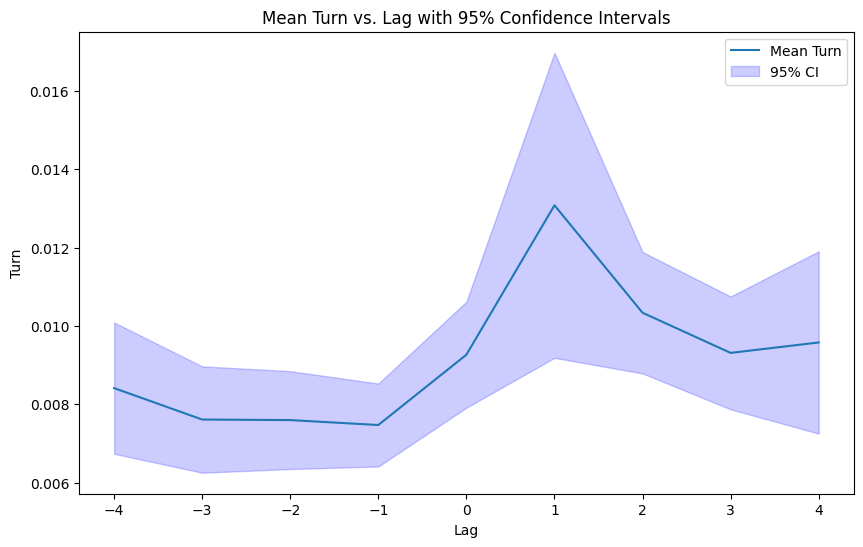

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming 'df' is your DataFrame and it has the columns 'turn' and 'lag'
df['turn'] = df['TR.Volume'] / df['TR.SharesOutstanding']

# Group by 'lag' and calculate the mean and standard error of 'turn'
grouped = df[(df['lag']>-5) & (df['lag']<5)].groupby('lag')['turn'].agg(['mean', 'count', 'std'])
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# Calculate the 95% confidence intervals
grouped['ci95_hi'] = grouped['mean'] + 1.96 * grouped['sem']
grouped['ci95_lo'] = grouped['mean'] - 1.96 * grouped['sem']

# Check the calculated values
print(grouped.head())

# Plot the mean 'turn' with 95% confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped['mean'], label='Mean Turn')
plt.fill_between(grouped.index, grouped['ci95_lo'], grouped['ci95_hi'], color='b', alpha=0.2, label='95% CI')

# Adding labels and title
plt.xlabel('Lag')
plt.ylabel('Turn')
plt.title('Mean Turn vs. Lag with 95% Confidence Intervals')

# Adding a legend
plt.legend()

# Show the plot
plt.show()